In [1]:

from __future__ import print_function
import os

from skimage.transform import resize

from skimage.io import imsave

import numpy as np

from keras.models import Model

from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, Conv2DTranspose

from keras.optimizers import Adam

from keras.callbacks import ModelCheckpoint

from keras import backend as K
#make sure to attach libraries : keras , tensorflow, matplotlib, pillow ,scikit-image, opencv-contrib-python


Using TensorFlow backend.

In [2]:
%fs ls /mnt/home/membrane/

path,name,size
dbfs:/mnt/home/membrane/test/,test/,0
dbfs:/mnt/home/membrane/test-volume.tif,test-volume.tif,7871660
dbfs:/mnt/home/membrane/train/,train/,0
dbfs:/mnt/home/membrane/train-labels.tif,train-labels.tif,7869573
dbfs:/mnt/home/membrane/train-volume.tif,train-volume.tif,7870730


In [3]:

K.set_image_data_format('channels_last')  # TF dimension ordering in this code



img_rows = 256

img_cols = 256



smooth = 1.



def dice_coef(y_true, y_pred):

    y_true_f = K.flatten(y_true)

    y_pred_f = K.flatten(y_pred)

    intersection = K.sum(y_true_f * y_pred_f)

    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)





def dice_coef_loss(y_true, y_pred):

    return -dice_coef(y_true, y_pred)

In [4]:

pretrained_weights=None,
input_size=(256,256,1)


inputs = Input(input_size)
def get_unet():

    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)

    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)

    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)



    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)

    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)



    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)

    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)



    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)

    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)



    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)



    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)

    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)

    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)



    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)

    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)

    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)



    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)

    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)

    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)



    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)

    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)

    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)



    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)



    model = Model(inputs=[inputs], outputs=[conv10])


    ##### modify from source to use normal binary_crossentropy loss 
    #model.compile(optimizer=Adam(lr=1e-5), loss=dice_coef_loss, metrics=[dice_coef])
    model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])


    return model

In [5]:
from __future__ import print_function
from keras.preprocessing.image import ImageDataGenerator
import numpy as np 
import os
import glob
import skimage.io as io
import skimage.transform as trans
#### data preperation steps
Sky = [128,128,128]
Building = [128,0,0]
Pole = [192,192,128]
Road = [128,64,128]
Pavement = [60,40,222]
Tree = [128,128,0]
SignSymbol = [192,128,128]
Fence = [64,64,128]
Car = [64,0,128]
Pedestrian = [64,64,0]
Bicyclist = [0,128,192]
Unlabelled = [0,0,0]

COLOR_DICT = np.array([Sky, Building, Pole, Road, Pavement,
                          Tree, SignSymbol, Fence, Car, Pedestrian, Bicyclist, Unlabelled])


def adjustData(img,mask,flag_multi_class,num_class):
    if(flag_multi_class):
        img = img / 255
        mask = mask[:,:,:,0] if(len(mask.shape) == 4) else mask[:,:,0]
        new_mask = np.zeros(mask.shape + (num_class,))
        for i in range(num_class):
            #for one pixel in the image, find the class in mask and convert it into one-hot vector
            #index = np.where(mask == i)
            #index_mask = (index[0],index[1],index[2],np.zeros(len(index[0]),dtype = np.int64) + i) if (len(mask.shape) == 4) else (index[0],index[1],np.zeros(len(index[0]),dtype = np.int64) + i)
            #new_mask[index_mask] = 1
            new_mask[mask == i,i] = 1
        new_mask = np.reshape(new_mask,(new_mask.shape[0],new_mask.shape[1]*new_mask.shape[2],new_mask.shape[3])) if flag_multi_class else np.reshape(new_mask,(new_mask.shape[0]*new_mask.shape[1],new_mask.shape[2]))
        mask = new_mask
    elif(np.max(img) > 1):
        img = img / 255
        mask = mask /255
        mask[mask > 0.5] = 1
        mask[mask <= 0.5] = 0
    return (img,mask)



def trainGenerator(batch_size,train_path,image_folder,mask_folder,aug_dict,image_color_mode = "grayscale",
                    mask_color_mode = "grayscale",image_save_prefix  = "image",mask_save_prefix  = "mask",
                    flag_multi_class = False,num_class = 2,save_to_dir = None,target_size = (256,256),seed = 1):
    '''
    can generate image and mask at the same time
    use the same seed for image_datagen and mask_datagen to ensure the transformation for image and mask is the same
    if you want to visualize the results of generator, set save_to_dir = "your path"
    '''
    image_datagen = ImageDataGenerator(**aug_dict)
    mask_datagen = ImageDataGenerator(**aug_dict)
    image_generator = image_datagen.flow_from_directory(
        train_path,
        classes = [image_folder],
        class_mode = None,
        color_mode = image_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = image_save_prefix,
        seed = seed)
    mask_generator = mask_datagen.flow_from_directory(
        train_path,
        classes = [mask_folder],
        class_mode = None,
        color_mode = mask_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = mask_save_prefix,
        seed = seed)
    train_generator = zip(image_generator, mask_generator)
    for (img,mask) in train_generator:
        img,mask = adjustData(img,mask,flag_multi_class,num_class)
        yield (img,mask)



def testGenerator(test_path,num_image = 30,target_size = (256,256),flag_multi_class = False,as_gray = True):
    for i in range(num_image):
        img = io.imread(os.path.join(test_path,"%d.png"%i),as_gray = as_gray)
        img = img / 255
        img = trans.resize(img,target_size)
        img = np.reshape(img,img.shape+(1,)) if (not flag_multi_class) else img
        img = np.reshape(img,(1,)+img.shape)
        yield img


def geneTrainNpy(image_path,mask_path,flag_multi_class = False,num_class = 2,image_prefix = "image",mask_prefix = "mask",image_as_gray = True,mask_as_gray = True):
    image_name_arr = glob.glob(os.path.join(image_path,"%s*.png"%image_prefix))
    image_arr = []
    mask_arr = []
    for index,item in enumerate(image_name_arr):
        img = io.imread(item,as_gray = image_as_gray)
        img = np.reshape(img,img.shape + (1,)) if image_as_gray else img
        mask = io.imread(item.replace(image_path,mask_path).replace(image_prefix,mask_prefix),as_gray = mask_as_gray)
        mask = np.reshape(mask,mask.shape + (1,)) if mask_as_gray else mask
        img,mask = adjustData(img,mask,flag_multi_class,num_class)
        image_arr.append(img)
        mask_arr.append(mask)
    image_arr = np.array(image_arr)
    mask_arr = np.array(mask_arr)
    return image_arr,mask_arr


def labelVisualize(num_class,color_dict,img):
    img = img[:,:,0] if len(img.shape) == 3 else img
    img_out = np.zeros(img.shape + (3,))
    for i in range(num_class):
        img_out[img == i,:] = color_dict[i]
    return img_out / 255



def saveResult(save_path,npyfile,flag_multi_class = False,num_class = 2):
    for i,item in enumerate(npyfile):
        img = labelVisualize(num_class,COLOR_DICT,item) if flag_multi_class else item[:,:,0]
        io.imsave(os.path.join(save_path,"%d_predict.png"%i),img)

In [6]:
import os
import sys
os.listdir("/dbfs/mnt/home/membrane/train/")
    

Out[ 5 ]: ['aug', 'image', 'label']

In [7]:
# workaround 
from PIL import Image
def register_extension(id, extension): Image.EXTENSION[extension.lower()] = id.upper()
Image.register_extension = register_extension
def register_extensions(id, extensions): 
  for extension in extensions: register_extension(id, extension)
Image.register_extensions = register_extensions

In [8]:
data_gen_args = dict(rotation_range=0.2,
                    width_shift_range=0.05,
                    height_shift_range=0.05,
                    shear_range=0.05,
                    zoom_range=0.05,
                    horizontal_flip=True,
                    fill_mode='nearest')
myGene = trainGenerator(2,'/dbfs/mnt/home/membrane/train','image','label',data_gen_args,save_to_dir = None)
model = get_unet()
model_checkpoint = ModelCheckpoint('/dbfs/mnt/home/'+'unet_membrane.hdf5', monitor='loss',verbose=1, save_best_only=True)
model.fit_generator(myGene,steps_per_epoch=10,epochs=3,callbacks=[model_checkpoint])

Epoch 1/20
Found 30 images belonging to 1 classes.
Found 30 images belonging to 1 classes.

 1/10 [==>...........................] - ETA: 48s - loss: 0.7013 - acc: 0.1946
 2/10 [=====>........................] - ETA: 26s - loss: 0.7007 - acc: 0.1960
 3/10 [========>.....................] - ETA: 18s - loss: 0.7002 - acc: 0.2002
 4/10 [===========>..................] - ETA: 13s - loss: 0.6995 - acc: 0.2094
 5/10 [==============>...............] - ETA: 10s - loss: 0.6989 - acc: 0.2105
 6/10 [=================>............] - ETA: 7s - loss: 0.6984 - acc: 0.2167 
 7/10 [====================>.........] - ETA: 5s - loss: 0.6979 - acc: 0.2222
 8/10 [=======================>......] - ETA: 3s - loss: 0.6975 - acc: 0.2255
 9/10 [==========================>...] - ETA: 1s - loss: 0.6971 - acc: 0.2418
10/10 [==============================] - 17s 2s/step - loss: 0.6966 - acc: 0.2763

Epoch 00001: loss improved from inf to 0.69664, saving model to /dbfs/mnt/home/unet_membrane.hdf5
Epoch 2/20

 1/10 [==>...........................] - ETA: 13s - loss: 0.6922 - acc: 0.6968
 2/10 [=====>........................] - ETA: 11s - loss: 0.6918 - acc: 0.7333
 3/10 [========>.....................] - ETA: 10s - loss: 0.6915 - acc: 0.7444
 4/10 [===========>..................] - ETA: 8s - loss: 0.6912 - acc: 0.7506 
 5/10 [==============>...............] - ETA: 7s - loss: 0.6908 - acc: 0.7575
 6/10 [=================>............] - ETA: 5s - loss: 0.6904 - acc: 0.7657
 7/10 [====================>.........] - ETA: 4s - loss: 0.6900 - acc: 0.7666
 8/10 [=======================>......] - ETA: 2s - loss: 0.6896 - acc: 0.7693
 9/10 [==========================>...] - ETA: 1s - loss: 0.6891 - acc: 0.7729
10/10 [==============================] - 14s 1s/step - loss: 0.6887 - acc: 0.7720

Epoch 00002: loss improved from 0.69664 to 0.68875, saving model to /dbfs/mnt/home/unet_membrane.hdf5
Epoch 3/20

 1/10 [==>...........................] - ETA: 12s - loss: 0.6839 - acc: 0.7868
 2/10 [=====>........................] - ETA: 11s - loss: 0.6836 - acc: 0.7750
 3/10 [========>.....................] - ETA: 10s - loss: 0.6829 - acc: 0.7826
 4/10 [===========>..................] - ETA: 8s - loss: 0.6824 - acc: 0.7817 
 5/10 [==============>...............] - ETA: 7s - loss: 0.6818 - acc: 0.7816
 6/10 [=================>............] - ETA: 5s - loss: 0.6809 - acc: 0.7832
 7/10 [====================>.........] - ETA: 4s - loss: 0.6802 - acc: 0.7804
 8/10 [=======================>......] - ETA: 2s - loss: 0.6795 - acc: 0.7777
 9/10 [==========================>...] - ETA: 1s - loss: 0.6787 - acc: 0.7760
10/10 [==============================] - 13s 1s/step - loss: 0.6774 - acc: 0.7771

Epoch 00003: loss improved from 0.68875 to 0.67739, saving model to /dbfs/mnt/home/unet_membrane.hdf5
Epoch 4/20

 1/10 [==>...........................] - ETA: 12s - loss: 0.6597 - acc: 0.8176
 2/10 [=====>........................] - ETA: 11s - loss: 0.6580 - acc: 0.8084
 3/10 [========>.....................] - ETA: 10s - loss: 0.6557 - acc: 0.8000
 4/10 [===========>..................] - ETA: 8s - loss: 0.6528 - acc: 0.7940 
 5/10 [==============>...............] - ETA: 7s - loss: 0.6495 - acc: 0.7898
 6/10 [=================>............] - ETA: 5s - loss: 0.6427 - acc: 0.7921
 7/10 [====================>.........] - ETA: 4s - loss: 0.6374 - acc: 0.7876
 8/10 [=======================>......] - ETA: 2s - loss: 0.6306 - acc: 0.7836
 9/10 [==========================>...] - ETA: 1s - loss: 0.6234 - acc: 0.7800
10/10 [==============================] - 13s 1s/step - loss: 0.6123 - acc: 0.7816

Epoch 00004: loss improved from 0.67739 to 0.61231, saving model to /dbfs/mnt/home/unet_membrane.hdf5
Epoch 5/20

 1/10 [==>...........................] - ETA: 13s - loss: 0.6048 - acc: 0.7559
 2/10 [=====>........................] - ETA: 11s - loss: 0.5563 - acc: 0.7805
 3/10 [========>.....................] - ETA: 10s - loss: 0.5432 - acc: 0.7833
 4/10 [===========>..................] - ETA: 8s - loss: 0.53

In [9]:
from keras.models import model_from_json
import os
import sys
"""
# serialize model to JSON

model_json = model.to_json()
with open('/dbfs/mnt/home/'+"best_unet_model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights('/dbfs/mnt/home/'+"best_unet_model.h5")
print("Saved unet_model to disk")
"""
# later...
 
# load json and create model
json_file = open('/dbfs/mnt/home/'+'best_unet_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights('/dbfs/mnt/home/'+"best_unet_model.h5")
print("Loading unet_model from disk")
 
# evaluate loaded model on test data
loaded_model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])
#score = loaded_model.evaluate(X, Y, verbose=0)

Saved unet_model to disk
Loading unet_model from disk

In [10]:
%fs ls '/mnt/home/'

path,name,size
dbfs:/mnt/home/BreastCancerData.csv,BreastCancerData.csv,14939
dbfs:/mnt/home/best_unet_model.h5,best_unet_model.h5,31119136
dbfs:/mnt/home/best_unet_model.json,best_unet_model.json,17428
dbfs:/mnt/home/data.py,data.py,5199
dbfs:/mnt/home/faces/,faces/,0
dbfs:/mnt/home/main.py,main.py,851
dbfs:/mnt/home/membrane/,membrane/,0
dbfs:/mnt/home/mixture_data.csv,mixture_data.csv,7800
dbfs:/mnt/home/unet_membrane.hdf5,unet_membrane.hdf5,93275520


In [11]:
testGene = testGenerator('/dbfs/mnt/home'+"/membrane/test")

#model.load_weights("unet_membrane.hdf5")
results = loaded_model.predict_generator(testGene,30,verbose=1)
saveResult('/dbfs/mnt/home'+"/membrane/test",results)

/databricks/python/lib/python3.5/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
 warn("The default mode, 'constant', will be changed to 'reflect' in "
/databricks/python/lib/python3.5/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
 warn("Anti-aliasing will be enabled by default in skimage 0.15 to "

 1/30 [>.............................] - ETA: 25s
 2/30 [=>............................] - ETA: 15s
 3/30 [==>...........................] - ETA: 12s
 4/30 [===>..........................] - ETA: 10s
 5/30 [====>.........................] - ETA: 9s 
 6/30 [=====>........................] - ETA: 8s
 7/30 [======>.......................] - ETA: 7s
 8/30 [=======>......................] - ETA: 6s
 9/30 [========>.....................] - ETA: 6s
10/30 [=========>....................] - ETA: 5s
11/30 [==========>...................] - ETA: 5s
12/30 [===========>..................] - ETA: 4s
13/30 [============>.................] - ETA: 4s
14/30 [=============>................] - ETA: 4s
15/30 [==============>...............] - ETA: 3s
16/30 [===============>..............] - ETA: 3s
17/30 [================>.............] - ETA: 3s
18/30 [=================>............] - ETA: 3s
19/30 [==================>...........] - ETA: 2s
20/30 [===================>..........] - ETA: 2s
21/30 [====================>.........] - ETA: 2s
22/30 [=====================>........] - ETA: 1s
23/30 [======================>.......] - ETA: 1s
24/30 [=======================>......] - ETA: 1s
25/30 [========================>.....] - ETA: 1s
26/30 [=========================>....] - ETA: 0s
27/30 [==========================>...] - ETA: 0s
28/30 [===========================>..] - ETA: 0s
29/30 [============================>.] - ETA: 0s
30/30 [==============================] - 7s 223ms/step
/databricks/python/lib/python3.5/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float32 to uint16
 .format(dtypeobj_in, dtypeobj_out))

In [12]:
import random
testpath='/dbfs/mnt/home/membrane/test/'
testlist=os.listdir(testpath)

rn=random.randint(0,30)
testlist[rn],testlist[rn+1]
test=plt.imread(testpath+testlist[rn])
testmask=plt.imread(testpath+testlist[rn+1])

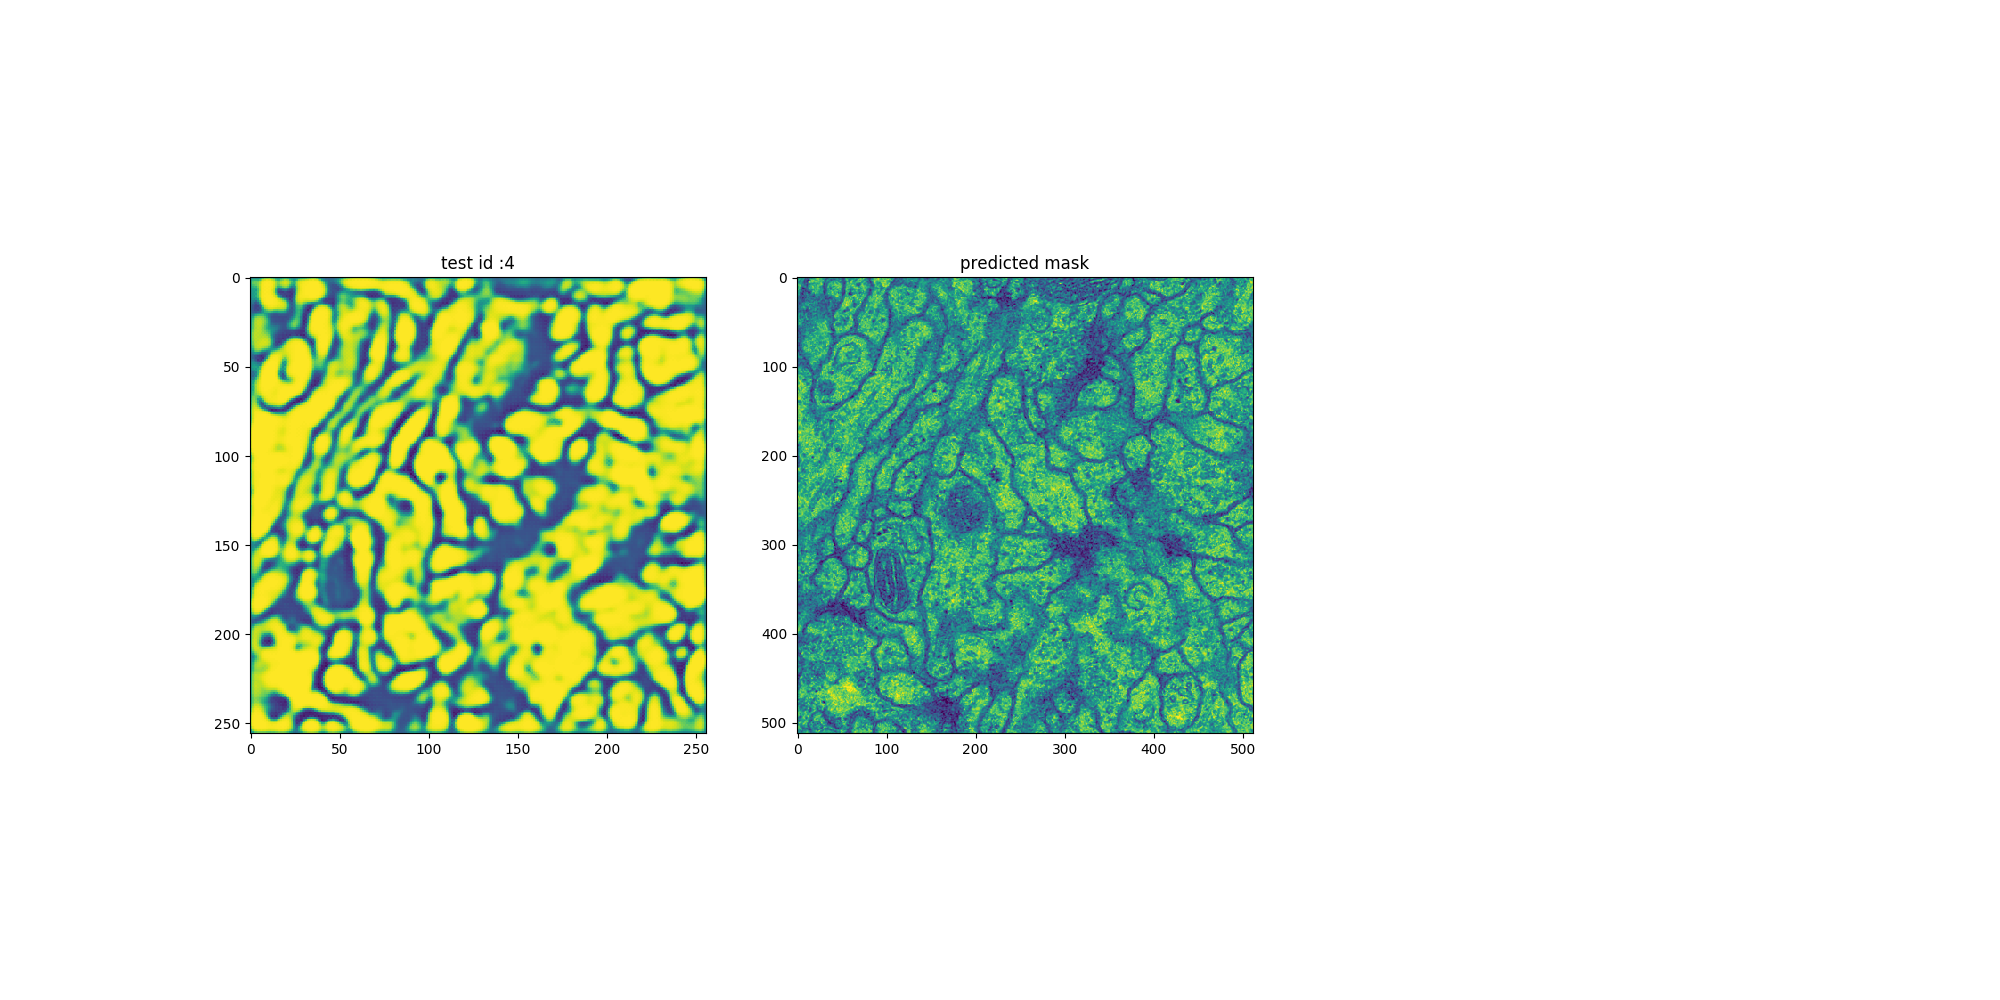

In [13]:
from skimage.transform import rescale, resize, downscale_local_mean
from matplotlib import pyplot as plt
from IPython.core.pylabtools import figsize
%matplotlib inline

figsize(20, 10)
fig = plt.figure()

plt.subplot(1, 3, 1)
plt.imshow(test)
plt.title("test id :{}".format(str(rn)))
plt.subplot(1, 3, 2)
plt.imshow(testmask)
plt.title("predicted mask")

display(plt.show())
pass